<a href="https://colab.research.google.com/github/haricash/deep-learning-projects/blob/main/galaxy_merger_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying mergers using CNNs

In [1]:
# imports

# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# nn in keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# neural net in pytorch (need to try)
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# help from sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [ ]:
version = "pristine"

In [ ]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 5.12 s, sys: 8.25 s, total: 13.4 s
Wall time: 56.8 s


In the above, we have used astropy's FITS format to load the FITS data into the program. Need to read astropy fits documentation anyways lol. Also need to understand what these headers mean in the next cell.

In [ ]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                15426                                                  
EXTEND  =                    T                                                  
NAME1   = 'ImageX  '                                                            
NAME2   = 'ImageY  '                                                            
NAME3   = 'filter  '           / F814W,F356W,F160W                              
NAME4   = 'object  '                                                            
EXTNAME = 'Images  '        

In [ ]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

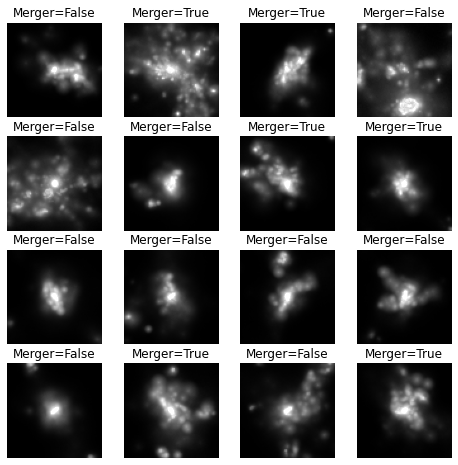

In [ ]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8)) 

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))
    
    ax.axis('off')
    
plt.show()

In [ ]:
X = hdu[0].data
y = hdu[1].data

X = np.asarray(X).astype("float32")
y = np.asarray(y).astype("float32")

In [ ]:
# First we split into training and validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Then we split into testing and validation
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=42, shuffle=True)

We'd like to rewrite the image array as  (number_of_images, image_width, image_length, 3)

In [ ]:
image_size = np.shape(X_train)[2]

X_train = X_train.reshape(-1,image_size, image_size, 3)
X_valid = X_valid.reshape(-1,image_size, image_size, 3)
X_test = X_test.reshape(-1,image_size, image_size, 3)

In [ ]:
batch_size = 8
num_workers = 2

In [ ]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

In [ ]:
# train_data = torch.utils.data.DataLoader(X_train, batch_size=batch_size,
                                        #  num_workers=num_workers)
# valid_data = torch.utils.data.DataLoader(X_valid, batch_size=batch_size,
                                        #  num_workers=num_workers)
# test_data = torch.utils.data.DataLoader(X_test, batch_size=batch_size,
                                        #  num_workers=num_workers)

### Constructing the CNN

In [ ]:
# class ConvNet(nn.Module):
#   """A simple CNN model for image classification"""

#   def __init__(self):
#     """Initialize the network"""
#     super(ConvNet, self).__init__()

#     self.conv1 = nn.Conv2d(3,8,5)
#     self.batch_norm1 = nn.BatchNorm2d(8)
#     self.pool1 = nn.MaxPool2d(2,2, padding=1)
#     self.drop1 - nn.Dropout(p=0.5)

#     self.conv2 = nn.Conv2d(8,16,3)
#     self.batch_norm2 = nn.BatchNorm2d(16)
#     self.pool2 = nn.MaxPool2d(2,2, padding=1)
#     self.drop2 - nn.Dropout(p=0.5)

#     self.conv3 = nn.Conv2d(16,32,3)
#     self.batch_norm3 = nn.BatchNorm2d(32)
#     self.pool3 = nn.MaxPool2d(2,2, padding=1)
#     self.drop3 - nn.Dropout(p=0.5)

#     self.flat1 = nn.Flatten()
#     self.lin1 = nn.Linear()

In [ ]:
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

In [ ]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 37, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 16)        1168  

In [ ]:
nb_epoch = 20
batch_size = 128
shuffle = True

# Train
history = cnn.fit(X_train, y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(X_valid, y_valid),
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/20
85/85 [==============================] - 64s 740ms/step - loss: 0.6966 - accuracy: 0.5145 - val_loss: 0.6930 - val_accuracy: 0.5269
Epoch 2/20
85/85 [==============================] - 58s 686ms/step - loss: 0.6902 - accuracy: 0.5271 - val_loss: 0.6906 - val_accuracy: 0.5269
Epoch 3/20
85/85 [==============================] - 59s 695ms/step - loss: 0.6858 - accuracy: 0.5271 - val_loss: 0.6919 - val_accuracy: 0.5269
Epoch 4/20
85/85 [==============================] - 59s 690ms/step - loss: 0.6811 - accuracy: 0.6007 - val_loss: 0.6925 - val_accuracy: 0.5262
Epoch 5/20
85/85 [==============================] - 60s 705ms/step - loss: 0.6732 - accuracy: 0.6548 - val_loss: 0.6942 - val_accuracy: 0.5340
Epoch 6/20
85/85 [==============================] - 58s 685ms/step - loss: 0.6646 - accuracy: 0.6615 - val_loss: 0.7007 - val_accuracy: 0.5275
Epoch 7/20
85/85 [==============================] - 58s 687ms/step - loss: 0.6556 - accuracy: 0.6694 - val_loss: 0.7059 - val_accuracy: 0.5294

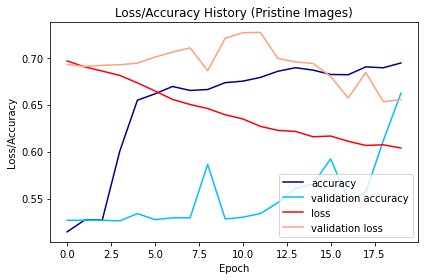

In [ ]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

In [ ]:
test_predictions = cnn.predict(X_test)

In [ ]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute merger predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Merger', 'No Merger'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Merger', 'No Merger'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center", 
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

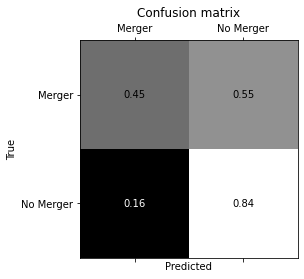

In [ ]:
plot_confusion_matrix(cnn, X_test, y_test)